# Web Scrapping - Preços da Apple
## Projeto Individual - Tiago Vitorino Seixas

Este notebook contém um projeto cujo objetivo é determinar dentre os países das Américas e da Europa quais tem os melhores e piores preços de dispositivos Apple. As fontes consultadas incluem:
- O site da apple hospedado em diferentes países
- A tabela de cotação do banco central do brasil (conversão de valores)

Os dados do site da Apple são alocados dinâmicamente, então além do BeautifulSoup, também foi necessário usar a biblioteca selenium.

Usou-se pandas para manipular os dados.

In [70]:
# para extrair informações de páginas HTML
from bs4 import BeautifulSoup

# Para criar um Data Frame
import pandas as pd

import re

from datetime import datetime, timedelta

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

import time

import matplotlib.pyplot as plt

from tqdm import tqdm

Abre página Chrome para usar o Selenium.

In [71]:
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
driver.set_page_load_timeout(50)

Pega os urls da apple dos países das Américas e da Europa

In [65]:
# Getting all country hrefs (for Europe and the Americas)
url = 'https://www.apple.com/choose-country-region/'

driver.get(url)
driver.implicitly_wait(3000)
time.sleep(2)

country_soup = BeautifulSoup(driver.page_source, 'html.parser')

main = country_soup.find('main')
regioes_linguas = {}
for region in main.find_all('section', class_='category'):
    lista_linguas = []
    region_name = region.get('data-analytics-section-engagement').replace('name:', '')
    if region_name not in regioes_linguas.keys():
        regioes_linguas[region_name] = []
    for button in region.find_all('a', class_='block'):
        href = button.get('href')
        lista_linguas.append(href)
    regioes_linguas[region_name] = list(set(lista_linguas))

lista_linguas = regioes_linguas['north-america'] + regioes_linguas['latin-america'] + regioes_linguas['europe']

# Join hrefs with apple url (except for China, which has the full URL in the href)
apple_url = 'https://www.apple.com'
lista_url_paises = []
for lingua in lista_linguas:
    if lingua == 'https://www.apple.com.cn/':
        lista_url_paises.append(lingua)
    elif lingua != '/':
        lista_url_paises.append(apple_url+lingua)
    else:
        lista_url_paises.append(apple_url+'/')

Caso este notebook já tenha sido executado anteriormente, pega o dataframe no csv, e transforma em um dicionário para ser atualizado, caso contrário inicializa um dicionário vazio.

In [66]:
# If you already have a csv file, pull it's data to avoid repeat work
try:
    df_read = pd.read_csv('data_source.csv')

    old_dict_prices = {}
    for _, row in df_read.iterrows():
        region = row["region"]
        category = row["category"]
        product = row["product"]
        price = row["price"]
        date = row["date"]
        old_dict_prices.setdefault(region, {}).setdefault(category, {})['date'] = date
        old_dict_prices[region][category][product] = price
    old_dict_prices
except:
    old_dict_prices = {}

função que confere se os dados de um país já foram coletados hoje, para evitar retrabalho.

In [67]:
def check_if_fetched_today(dict_prices, pais, device, today):
    has_date = False
    has_current_date = False
    try:
        if len(dict_prices[pais][device].keys()) >= 1:
            try:
                has_date = 'date' in dict_prices[pais][device].keys()
                if str(dict_prices[pais][device]['date']) == str(today):
                    has_current_date = True
                else:
                    has_current_date = False
            except:
                pass
    except:
        pass

    return has_date, has_current_date

Para que uma comparação seja realizada entre os valores de produtos de diferentes países, é necessário converter os valores para uma mesma moeda, então no próximo bloco é coletada a tabela de conversão de moedas do Banco Central do Brasil.

In [68]:
# Fetching Brazilian Central Bank exchange rates
contador = 1
csv_read = True
column_names = [ "Data", "Cod Moeda", "Tipo", "Moeda", "Taxa Compra", "Taxa Venda", "Paridade Compra", "Paridade Venda"]

while contador < 10 and csv_read:
    most_recent_date = datetime.today()
    desired_date = most_recent_date - timedelta(days=contador)
    string_date = desired_date.strftime('%Y%m%d')
    try:
        exchange_rates_to_brl = pd.read_csv(f"https://www4.bcb.gov.br/Download/fechamento/{string_date}.csv", sep=';', header=None, names=column_names)
        csv_read = False
    except:
        contador += 1

No bloco abaixo, é realizada a coleta dos dados de dispositivos de todos os países.

In [72]:
iphone_url = 'iphone'
ipad_url = 'ipad'
mac_url = 'mac'
watch_url = 'watch'

dict_prices = {}

for url_pais in tqdm(lista_url_paises, desc="Processing"):
    pais = url_pais.replace('https://www.apple.com', '').replace('.', '').replace('/', '')
    if pais == '':
        pais = 'us' 

    dict_prices[pais] = {
        'iphone' : {},
        'ipad' : {},
        'mac' : {},
        'watch' : {},
        'passed' : 'true'
    }

    today = string_date

    # Check if iPhone data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'iphone', today)

    # List with hrefs of countries with problems in the website (Russia and Belarus)
    # Or that do not have any value exposed in the url and also do not have the apple watch tab (as of May 2025)
    list_excluded_countries = [
        'ru',
        'by',
        'li',
        'mk',
        'mt',
        'me',
    ]

    # List with hrefs of countries that do not have the apple watch tab available
    list_no_watch = [
        
    ]

    # If there isn't iPhone data, or if data is not from today, get iPhone data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+iphone_url)
            driver.implicitly_wait(3000)
            time.sleep(0.5)
            section_5_countries = [
                'fr',
                'es',
                'uk',
                'de',
                'it',
            ]
            section_3_countries = [
                'lu',
                'nl',
                'se',
                'at',
                'fi',
                'ie',
                'benl',
                'no',
                'befr',
                'pt',
                'dk'
            ]
            if pais in section_5_countries:
                iphone_path = '/html/body/main/section[5]/div[2]/div[2]/div/div[1]/div/ul'
            elif pais in section_3_countries:
                iphone_path = '/html/body/main/section[3]/div[2]/div[2]/div/div[1]/div/ul'
            else:
                iphone_path = '/html/body/main/section[4]/div[2]/div[2]/div[1]/div[1]/div/ul'
            iphone_ul_element = driver.find_element(By.XPATH, iphone_path)
            driver.execute_script("arguments[0].scrollIntoView();", iphone_ul_element)
            time.sleep(1)
            iphone_ul = BeautifulSoup(iphone_ul_element.get_attribute("outerHTML"), 'html.parser')
            iphone_li_list = iphone_ul.find_all('li')
            list_reject = ['', ' ', None]
            for li in iphone_li_list:
                title = li.find('p', class_ = 'product-tile-headline')
                price = li.find('span', class_ = 'sosumi-link-follows')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['iphone'][title] = price
                    dict_prices[pais]['iphone']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['iphone']['date'] = today
    else:
        dict_prices[pais]['iphone'] = old_dict_prices[pais]['iphone']
    
    # Check if iPad data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'ipad', today)

    # Get iPad data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+ipad_url)
            driver.implicitly_wait(3000)
            time.sleep(0.5)
            ipad_path = '/html/body/div/div/main/section[3]/div/div[2]/div/div[1]/ul'
            ipad_ul_element = driver.find_element(By.XPATH, ipad_path)
            driver.execute_script("arguments[0].scrollIntoView();", ipad_ul_element)
            time.sleep(1)
            ipad_ul = BeautifulSoup(ipad_ul_element.get_attribute("outerHTML"), 'html.parser')
            ipad_li_list = ipad_ul.find_all('li')
            list_reject = ['', ' ', None]
            for li in ipad_li_list:
                title = li.find('h3', class_ = 'typography_headline__zZkHA')
                price = li.find('p', class_ = 'ProductTile_pricing__mJzcd typography_bodyCopySemibold__RqR50')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['ipad'][title] = price
                    dict_prices[pais]['ipad']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['ipad']['date'] = today
    else:
        dict_prices[pais]['ipad'] = old_dict_prices[pais]['ipad']

    # Check if MacBook Air/Pro data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'mac', today)
    
    # Get MacBook Air/Pro data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+mac_url)
            driver.implicitly_wait(3000)
            time.sleep(0.5)

            mac_path = '/html/body/main/section[3]/div[2]/div[2]/div[1]/div[1]/div/ul'
            mac_path_list = list(mac_path)

            button_path = '/html/body/main/section[3]/div[2]/div[1]/ul/li[2]/button'
            button_path_list = list(button_path)

            if pais == 'us':
                mac_path_list[24] = '4'
                mac_path = ''.join(mac_path_list)
                button_path_list[24] = '4'
                button_path = ''.join(button_path_list)


            notebooks_ul_element = driver.find_element(By.XPATH, mac_path)
            driver.execute_script("arguments[0].scrollIntoView();", notebooks_ul_element)
            time.sleep(1)
            notebooks_ul = BeautifulSoup(notebooks_ul_element.get_attribute("outerHTML"), 'html.parser')

            desktops_button = driver.find_element(By.XPATH, button_path)
            driver.execute_script("arguments[0].scrollIntoView();", desktops_button)
            desktops_button.click()
            time.sleep(1)

            mac_path_list[-16] = '2'
            new_mac_path = ''.join(mac_path_list)
            desktops_ul_element = driver.find_element(By.XPATH, new_mac_path)
            desktops_ul = BeautifulSoup(desktops_ul_element.get_attribute("outerHTML"), 'html.parser')

            button_path_list[-9] = '3'
            new_button_path = ''.join(button_path_list)
            monitors_button = driver.find_element(By.XPATH, new_button_path)
            driver.execute_script("arguments[0].scrollIntoView();", monitors_button)
            monitors_button.click()
            time.sleep(1)

            mac_path_list[-16] = '3'
            new_mac_path = ''.join(mac_path_list)
            monitors_ul_element = driver.find_element(By.XPATH, new_mac_path)
            monitors_ul = BeautifulSoup(monitors_ul_element.get_attribute("outerHTML"), 'html.parser')

            mac_li_list = notebooks_ul.find_all('li') + desktops_ul.find_all('li') + monitors_ul.find_all('li') 
            list_reject = ['', ' ', None]
            for li in mac_li_list:
                title = li.find('p', class_ = 'product-tile-headline')
                price = li.find('p', class_ = 'product-tile-price product-tile-padding has-dynamic-content')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['mac'][title] = price
                    dict_prices[pais]['mac']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['mac']['date'] = today
    else:
        dict_prices[pais]['mac'] = old_dict_prices[pais]['mac']

    # Check if Apple Watch data has already been fetched today
    has_date, has_current_date = check_if_fetched_today(old_dict_prices, pais, 'watch', today)

    # Get Apple Watch data
    if (not has_date or not has_current_date) and pais not in list_excluded_countries:
        try:
            driver.get(url_pais+watch_url)
            driver.implicitly_wait(3000)
            # time.sleep(1)
            if pais == 'ca' or pais == 'cafr':
                watch_ul_element = driver.find_element(By.XPATH, '/html/body/main/section[5]/div[2]/div[1]/div/ul')
                time.sleep(0.5)
            else:
                watch_ul_element = driver.find_element(By.XPATH, '/html/body/main/section[4]/div[2]/div[1]/div/ul')
            driver.execute_script("arguments[0].scrollIntoView();", watch_ul_element)
            time.sleep(1)
            watch_ul = BeautifulSoup(watch_ul_element.get_attribute("outerHTML"), 'html.parser')
            watch_li_list = watch_ul.find_all('li')
            list_reject = ['', ' ', None]
            for li in watch_li_list:
                title = li.find('span', class_ = 'product-tile-headline typography-product-tile-headline')
                price = li.find('p', class_ = 'product-tile-price typography-product-tile-subheading product-tile-padding has-dynamic-content')
                if title not in list_reject and price not in list_reject:
                    title = title.text.replace('\xa0', ' ')
                    price = price.text.replace('\xa0', ' ')
                    dict_prices[pais]['watch'][title] = price
                    dict_prices[pais]['watch']['date'] = today
        except:
            dict_prices[pais]['passed'] = 'false'
    elif pais in list_excluded_countries:
        dict_prices[pais]['watch']['date'] = today
    else:
        dict_prices[pais]['watch'] = old_dict_prices[pais]['watch']

    try:
        if dict_prices[pais]['passed'] == 'true':
            pass
        else:
            print(f"Deu ruim {pais}")
    except:
        print(f"Deu ruim {pais}")


Processing: 100%|██████████| 56/56 [11:14<00:00, 12.05s/it]


O dicionário com os dados dos produtos coletados é convertido em um dataframe do pandas, que é então limpo para garantir que apenas os valores  de preço à vista serão levados em consideração, pondo todos os países em pé de igualdade.

In [73]:
# Convert dictionary into dataframe
flattened_data = []
for region, products in dict_prices.items():
    if "passed" in products:
        del products["passed"] 
    for category, items in products.items():
        for product, price in items.items():
            if region == '':
                considered_region = 'us'
            else:
                considered_region = region
            if product != 'date':
                flattened_data.append({
                    "region": considered_region.replace('"', '')  ,
                    "category": category.replace('"', '')  ,
                    "product": product.replace('"', '')  ,
                    "price": str(price).replace('"', '') ,
                    "date" : today
                })


df = pd.DataFrame(flattened_data)

df = df.dropna()
df = df[df["price"].str.strip() != ""]
df.map(lambda x: x.replace('\n', ''))
df["price"] = df["price"].str.replace(r"(?<=\d) (?=\d)", "", regex=True)
df["price"] = df["price"].str.replace(r"[.,](?=\d{3}\b)", "", regex=True)
df["price"] = df["price"].str.replace(r"[$€£]", " ", regex=True)
df["price"] = df["price"].str.replace(r"[A-Za-zÀ-ú]", " ", regex=True)
df["price"] = df["price"].str.replace(r"[^\d\s.,]|(?<!\d)[.,]|[.,](?!\d)", "", regex=True)
df["price"] = df["price"].str.replace(',', '.', regex=True)
def extract_full_price(price_string):
    numbers = [float(n.replace(",", "")) for n in re.findall(r"\d+(?:[\.,]\d+)?", price_string)]
    return max(numbers) if numbers else None

df["price"] = df["price"].apply(extract_full_price)
df.head()

,region,category,product,price,date
0,cafr,iphone,iPhone 16 Pro,1449.0,20250530
1,cafr,iphone,iPhone 16,1129.0,20250530
2,cafr,iphone,iPhone 16e,899.0,20250530
3,cafr,iphone,iPhone 15,999.0,20250530
4,cafr,ipad,iPad Pro,1399.0,20250530


Da tabela de conversão de moedas do banco central, são usadas apenas duas colunas, e o valor de conversão do real para o real (1:1) é adicionado à tabela, para evitar erros no código

In [74]:
# Get desired columns from exchange rate table, and add row with converion rate for the BRL (1 to 1)
desired_columns = ['Moeda', 'Taxa Venda']
exchange_rates_to_brl = exchange_rates_to_brl[desired_columns]
exchange_rates_to_brl = exchange_rates_to_brl.astype(str)
exchange_rates_to_brl["Taxa Venda"] = exchange_rates_to_brl["Taxa Venda"].str.replace(',', '.', regex=True)
exchange_rates_to_brl.loc[len(exchange_rates_to_brl)] = ["BRL", '1.00000000']
exchange_rates_to_brl["Taxa Venda"] = exchange_rates_to_brl["Taxa Venda"].astype(float)

#### Dicionário de conversão do href para a moeda do país

In [75]:
# Dictionary with the href (country) and their respective coins
convert_dict = {
    'us': 'USD', # Moeda EUA
    'cafr': 'CAD', # Moeda Canada
    'ca': 'CAD', # Moeda Canada
    'mx': 'MXN', # Moeda Mexico
    'cl': 'CLP', # Moeda Chile
    'br': 'BRL', # Moeda Brasil
    'lu': 'EUR', # Moeda Luxemburgo (Euro)
    'uk': 'GBP', # Moeda Reino Unido 
    'de': 'EUR', # Moeda Alemanha (Euro)
    'chfr': 'CHF', # Moeda Suica
    'ie': 'EUR', # Moeda Irlanda (Euro)
    'hu': 'HUF', # Moeda Hungria
    'chde': 'CHF', # Moeda Suica
    'no': 'NOK', # Moeda Noruega
    'fr': 'EUR', # Moeda Franca (Euro)
    'pt': 'EUR', # Moeda Portugal (Euro)
    'cz': 'CZK', # Moeda Tchequia
    'dk': 'DKK', # Moeda Dinamarca
    'benl': 'EUR', # Moeda Belgica (Euro)
    'at': 'EUR', # Moeda Austria (Euro)
    'befr': 'EUR', # Moeda Belgica (Euro)
    'nl': 'EUR', # Moeda Paises Baixos (Euro)
    'pl': 'PLN', # Moeda Polonia
    'it': 'EUR', # Moeda Italia (Euro)
    'es': 'EUR', # Moeda Espanha (Euro)
    'se': 'SEK', # Moeda Suecia
    'tr': 'TRY', # Moeda Turquia
    'fi': 'EUR', # Moeda Finlandia (Euro)
}

#### Dicionário de conversão do href para o nome do país

In [76]:
convert_country_dict = {
    'us': 'EUA', # Moeda EUA
    'cafr': 'Canada', # Moeda Canada
    'ca': 'Canada', # Moeda Canada
    'mx': 'Mexico', # Moeda Mexico
    'cl': 'Chile', # Moeda Chile
    'br': 'Brasil', # Moeda Brasil
    'lu': 'Luxemburgo', # Moeda Luxemburgo (Euro)
    'uk': 'Reino Unido', # Moeda Reino Unido 
    'de': 'Alemanha', # Moeda Alemanha (Euro)
    'chfr': 'Suica', # Moeda Suica
    'ie': 'Irlanda', # Moeda Irlanda (Euro)
    'hu': 'Hungria', # Moeda Hungria
    'chde': 'Suica', # Moeda Suica
    'no': 'Noruega', # Moeda Noruega
    'fr': 'Franca', # Moeda Franca (Euro)
    'pt': 'Portugal', # Moeda Portugal (Euro)
    'cz': 'Tchequia', # Moeda Tchequia
    'dk': 'Dinamarca', # Moeda Dinamarca
    'benl': 'Belgica', # Moeda Belgica (Euro)
    'at': 'Austria', # Moeda Austria (Euro)
    'befr': 'Belgica', # Moeda Belgica (Euro)
    'nl': 'Paises Baixos', # Moeda Paises Baixos (Euro)
    'pl': 'Polonia', # Moeda Polonia
    'it': 'Italia', # Moeda Italia (Euro)
    'es': 'Espanha', # Moeda Espanha (Euro)
    'se': 'Suecia', # Moeda Suecia
    'tr': 'Turquia', # Moeda Turquia
    'fi': 'Finlandia', # Moeda Finlandia (Euro)
}

In [77]:
# Merge exchange rates with data collected
region_df = df
region_df['money_code'] = region_df['region'].map(convert_dict)

merged_df = region_df.merge(exchange_rates_to_brl.rename(columns={'Moeda': 'money_code', 'Taxa Venda': 'exchange_rate'}), on='money_code', how='left')
merged_df['price'] = merged_df['price'].astype(float)
merged_df['price_brl'] = merged_df['price'] * merged_df['exchange_rate']
merged_df['price_brl'] = (merged_df['price_brl']).round(2)
merged_df = merged_df.drop(columns=['money_code', 'exchange_rate'])

No bloco abaixo, dados antigos e novos de preços de produtos por região são combinados, preenchendo valores ausentes e garantindo continuidade em caso de erro. Em seguida, a estrutura do dataframe é ajustada e adiciona a informação do país correspondente. O resultado é um conjunto de dados atualizado para análise.

In [78]:
# Update table

import warnings

warnings.filterwarnings("ignore")

try:
    update_df = pd.merge(df_read, merged_df, on=['region', 'category', 'product'], how='outer', suffixes=('_old', '_new'))
    update_df["date"] = update_df["date_new"].fillna(update_df["date_old"])  
    update_df["price_brl"] = update_df["price_brl_new"].fillna(update_df["price_brl_old"])
    update_df = update_df[['region', 'category', 'product', 'price', 'price_brl', 'date']]
except:
    update_df = merged_df
    update_df = update_df[['region', 'category', 'product', 'price', 'price_brl', 'date']]

update_df['country'] = update_df['region'].map(convert_country_dict) 

### Atenção!

Durante a realização do Web Scrapping do site da Apple, notou-se que MacBook Air e MacBook Pro tinham nome variável dependendo do país, e que na Polônia, os dispositivos Studio Display e Pro Display XDR, que estavam na aba monitores, da página de macs, tinham a palavra Monitor precedendo os seus nomes, então para bolar esta análise, esses dados foram corrigidos no bloco de código abaixo. No entanto, destaca-se que no futuro, esse bloco de código provavelmente deverá ser atualizado, conforme novos produtos aparecerem na loja.

In [79]:
update_df.loc[update_df['product'].str.contains('13', na=False), 'product'] = 'MacBook Air de 13 e 15 pol.'
update_df.loc[update_df['product'].str.contains('14', na=False), 'product'] = 'MacBook Pro de 14 e 16 pol.'
update_df.loc[update_df['product'].str.contains('Monitor Studio Display', na=False), 'product'] = 'Studio Display'
update_df.loc[update_df['product'].str.contains('Monitor Pro Display XDR', na=False), 'product'] = 'Pro Display XDR'

Por fim, os dados coletados são salvos no arquivo csv 'data_source', mencionado anteriormente

In [80]:
update_df.to_csv('data_source.csv', index=False)

Os dados do arquivo 'data_source.csv' são então guardados em uma variável, para a realização de análise. O motivo de não ter sido usada a variável do bloco anterior é para permitir ao usuário a possibilidade de apenas analisar os dados já previamente coletados, para que ele não precise rodar este notebook desde o começo toda vez.

In [81]:
data_source_df = pd.read_csv('data_source.csv')

## Primeira Análise - Visão Geral

Este primeiro gráfico apresentará uma comparação dos preços dos dispositivos de diferentes categorias entre vários países. Cada categoria de produto será destacada com uma cor específica, facilitando a visualização. Ao invés de um modelo onde as categorias mais baratas ocultam as mais caras, este gráfico expõe integralmente o preço total de todas as categorias. Os produtos de maior quantidade ou com preços mais altos estarão na base, servindo de referência visual, enquanto as demais categorias são empilhadas acima, sempre mantendo sua totalidade visível. Isso garante que todas as faixas de preço sejam apresentadas de maneira clara e comparativa.

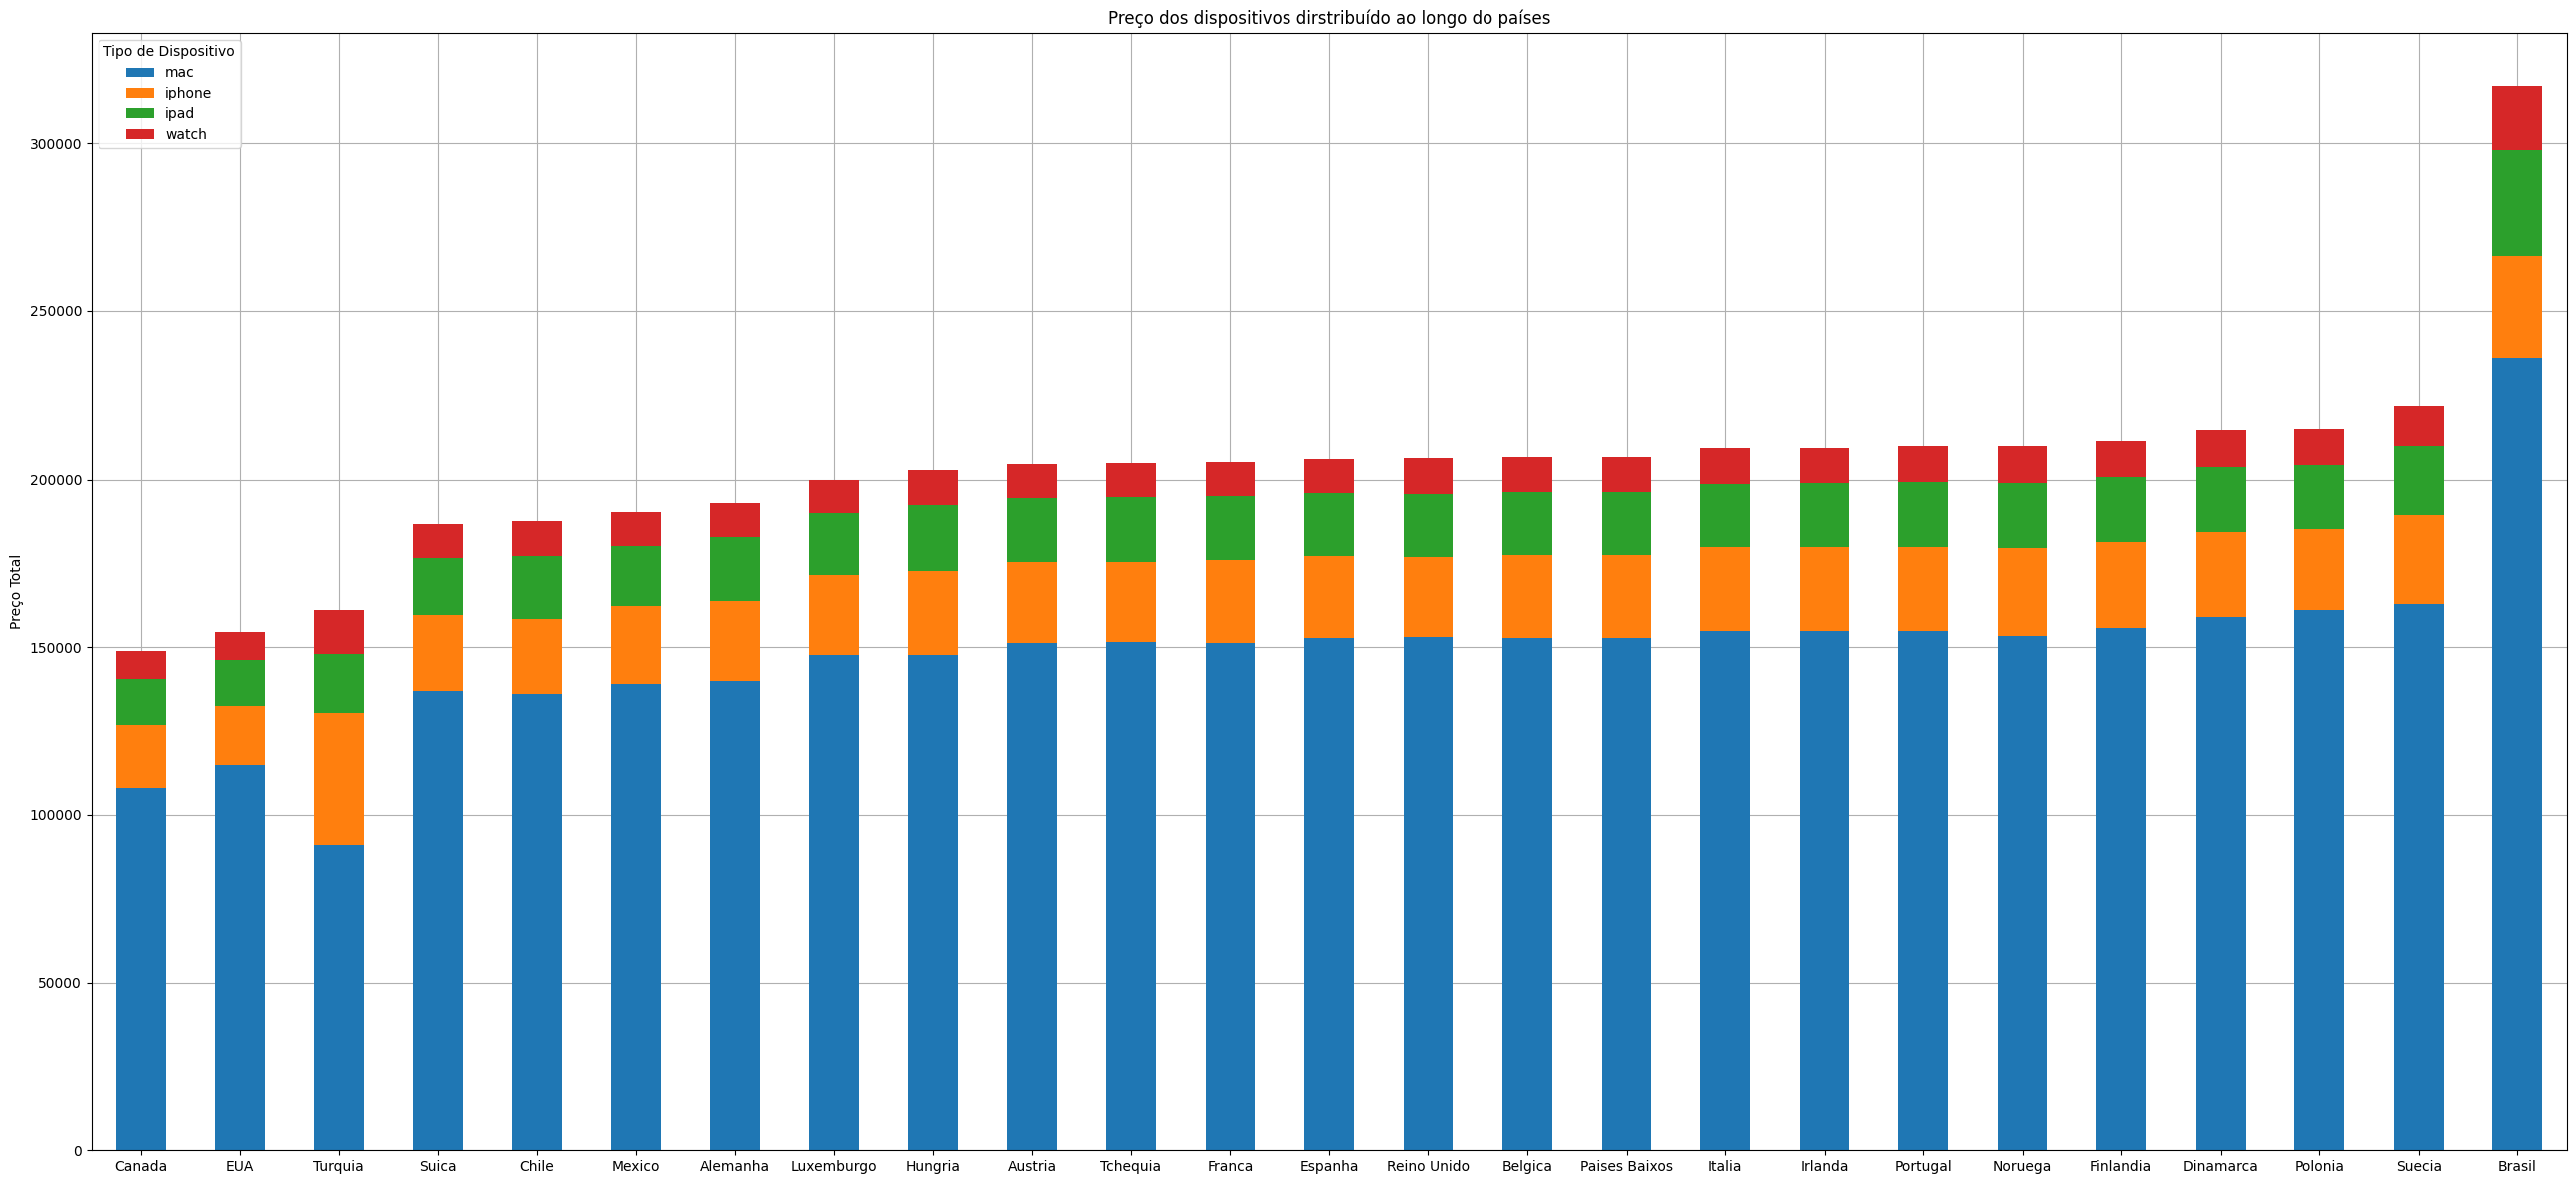

In [82]:
country_df = data_source_df.drop(columns=['region'])
country_df = country_df.drop_duplicates()

pivot_df = country_df.pivot_table(values='price_brl', index='country', columns='category', aggfunc='sum', fill_value=0)
pivot_table = pivot_df.reindex(['mac','iphone', 'ipad', 'watch'], axis=1)
pivot_table['sum_all'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='sum_all')
pivot_table = pivot_table.drop(columns=['sum_all'])
pivot_table.plot(kind='bar', stacked=True, figsize=(26, 12), zorder=2)
plt.title('Preço dos dispositivos dirstribuído ao longo do países')
plt.xlabel('')
plt.ylabel('Preço Total')
plt.legend(title='Tipo de Dispositivo')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.grid(True, zorder=1)
plt.show()

## Segunda Análise - Comparação de Preços de iPhones

O gráfico a seguir mostra o granular dos preços da categoria iphone distribuído pelos países do gráfico de visão geral. Um ponto de destaque é que esse é o único gráfico no qual o Brasil não tem os piores preços dentre os países analisados.

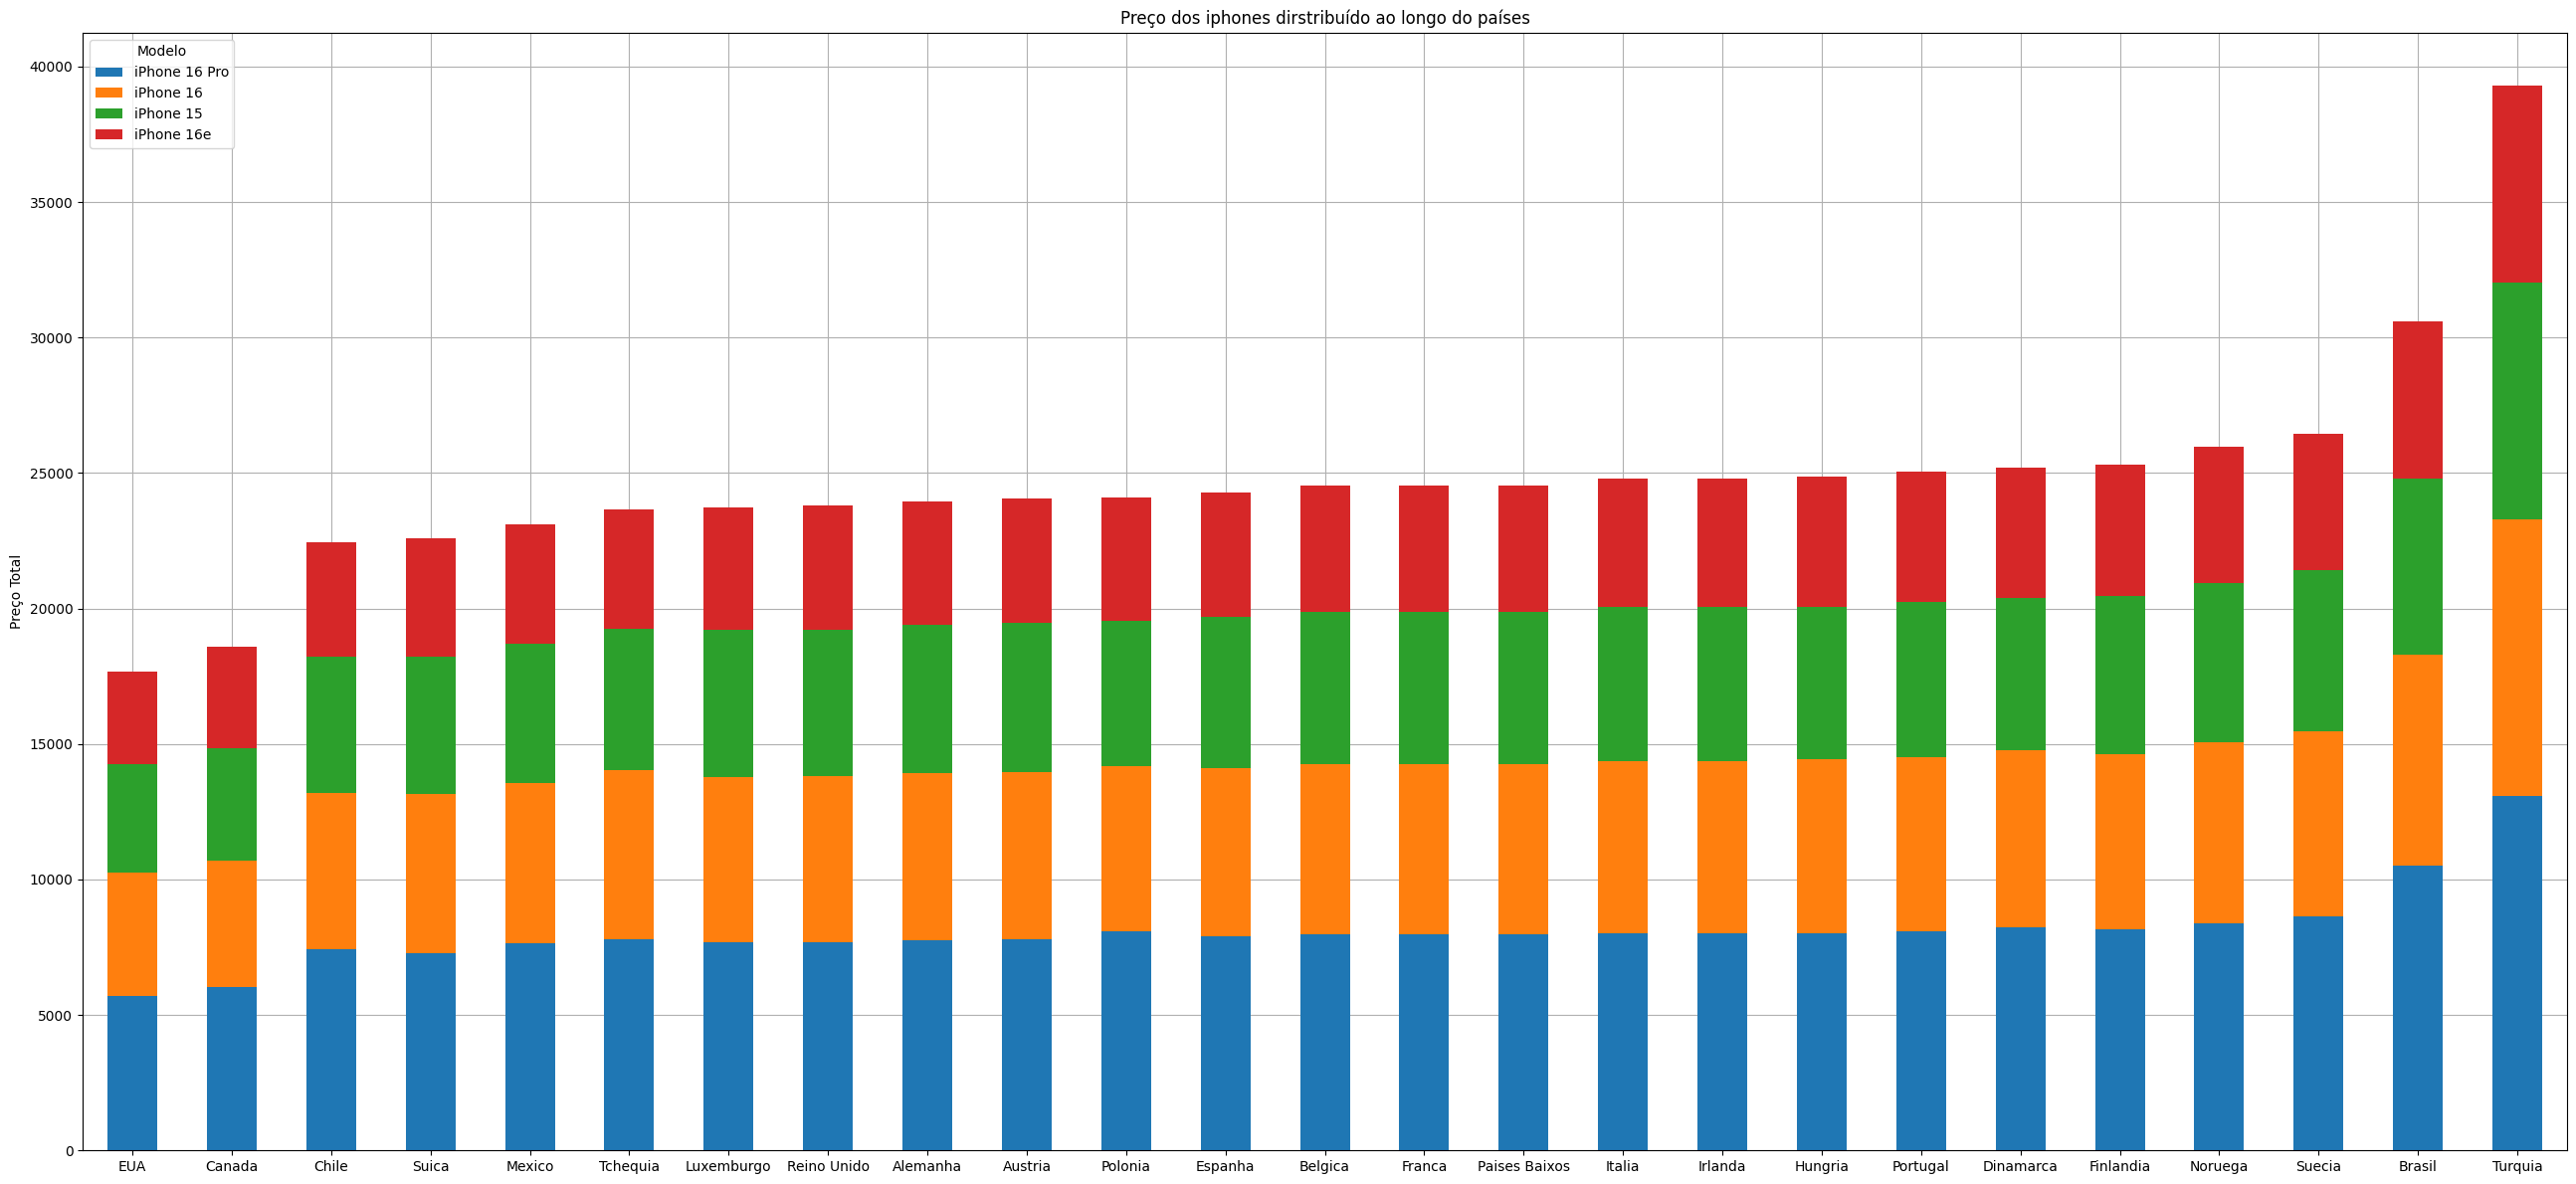

In [83]:
iphone_df = data_source_df.drop(columns=['region'])
iphone_df = iphone_df.drop_duplicates()
iphone_df = iphone_df[iphone_df['category'] == 'iphone']
iphone_df

pivot_df = iphone_df.pivot_table(values='price_brl', index='country', columns='product', aggfunc='sum', fill_value=0)
columns = pivot_df.iloc[3].sort_values(ascending=True).index.to_list()[::-1]
pivot_table = pivot_df.reindex(columns, axis=1)
pivot_table['sum_all'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='sum_all')
pivot_table = pivot_table.drop(columns=['sum_all'])
pivot_table.plot(kind='bar', stacked=True, figsize=(26, 12), zorder=2)
plt.title('Preço dos iphones dirstribuído ao longo do países')
plt.xlabel('')
plt.ylabel('Preço Total')
plt.legend(title='Modelo')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.grid(True, zorder=1)
plt.show()

## Terceira Análise - Comparação de Preços de iPads

O gráfico a seguir mostra o granular dos preços da categoria ipad distribuído pelos países do gráfico de visão geral.

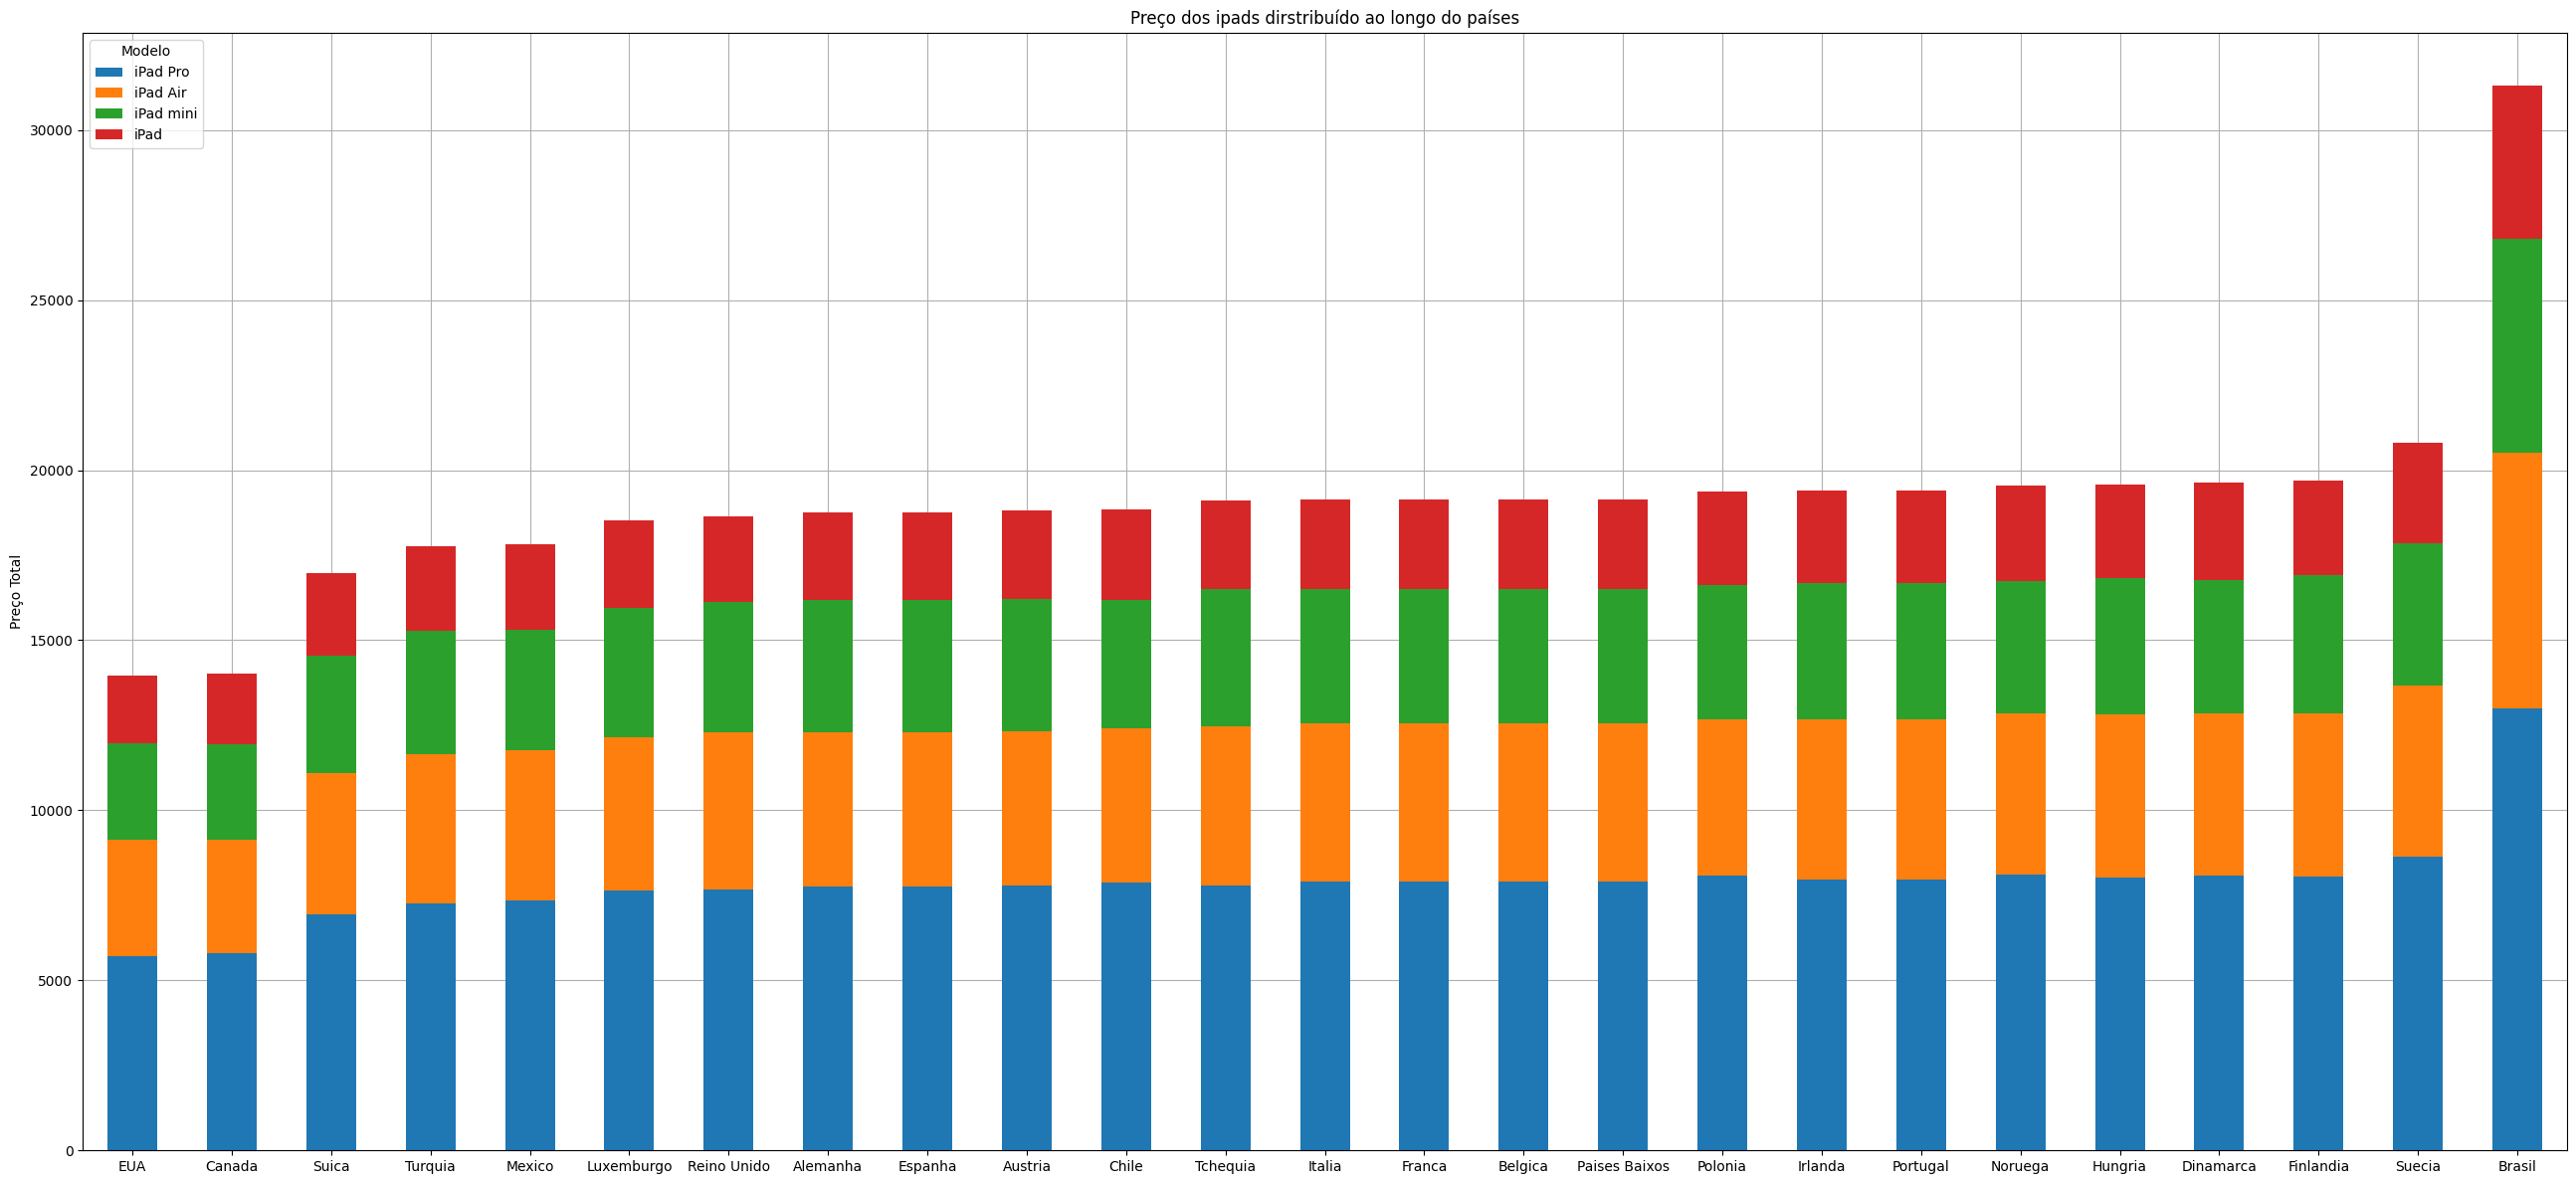

In [84]:
ipad_df = data_source_df.drop(columns=['region'])
ipad_df = ipad_df.drop_duplicates()
ipad_df = ipad_df[ipad_df['category'] == 'ipad']
ipad_df

pivot_df = ipad_df.pivot_table(values='price_brl', index='country', columns='product', aggfunc='sum', fill_value=0)
columns = pivot_df.iloc[3].sort_values(ascending=True).index.to_list()[::-1]
pivot_table = pivot_df.reindex(columns, axis=1)
pivot_table['sum_all'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='sum_all')
pivot_table = pivot_table.drop(columns=['sum_all'])
pivot_table.plot(kind='bar', stacked=True, figsize=(26, 12), zorder=2)
plt.title('Preço dos ipads dirstribuído ao longo do países')
plt.xlabel('')
plt.ylabel('Preço Total')
plt.legend(title='Modelo')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.grid(True, zorder=1)
plt.show()

## Quarta Análise - Comparação de Preços de Watches

O gráfico a seguir mostra o granular dos preços da categoria watch distribuído pelos países do gráfico de visão geral.

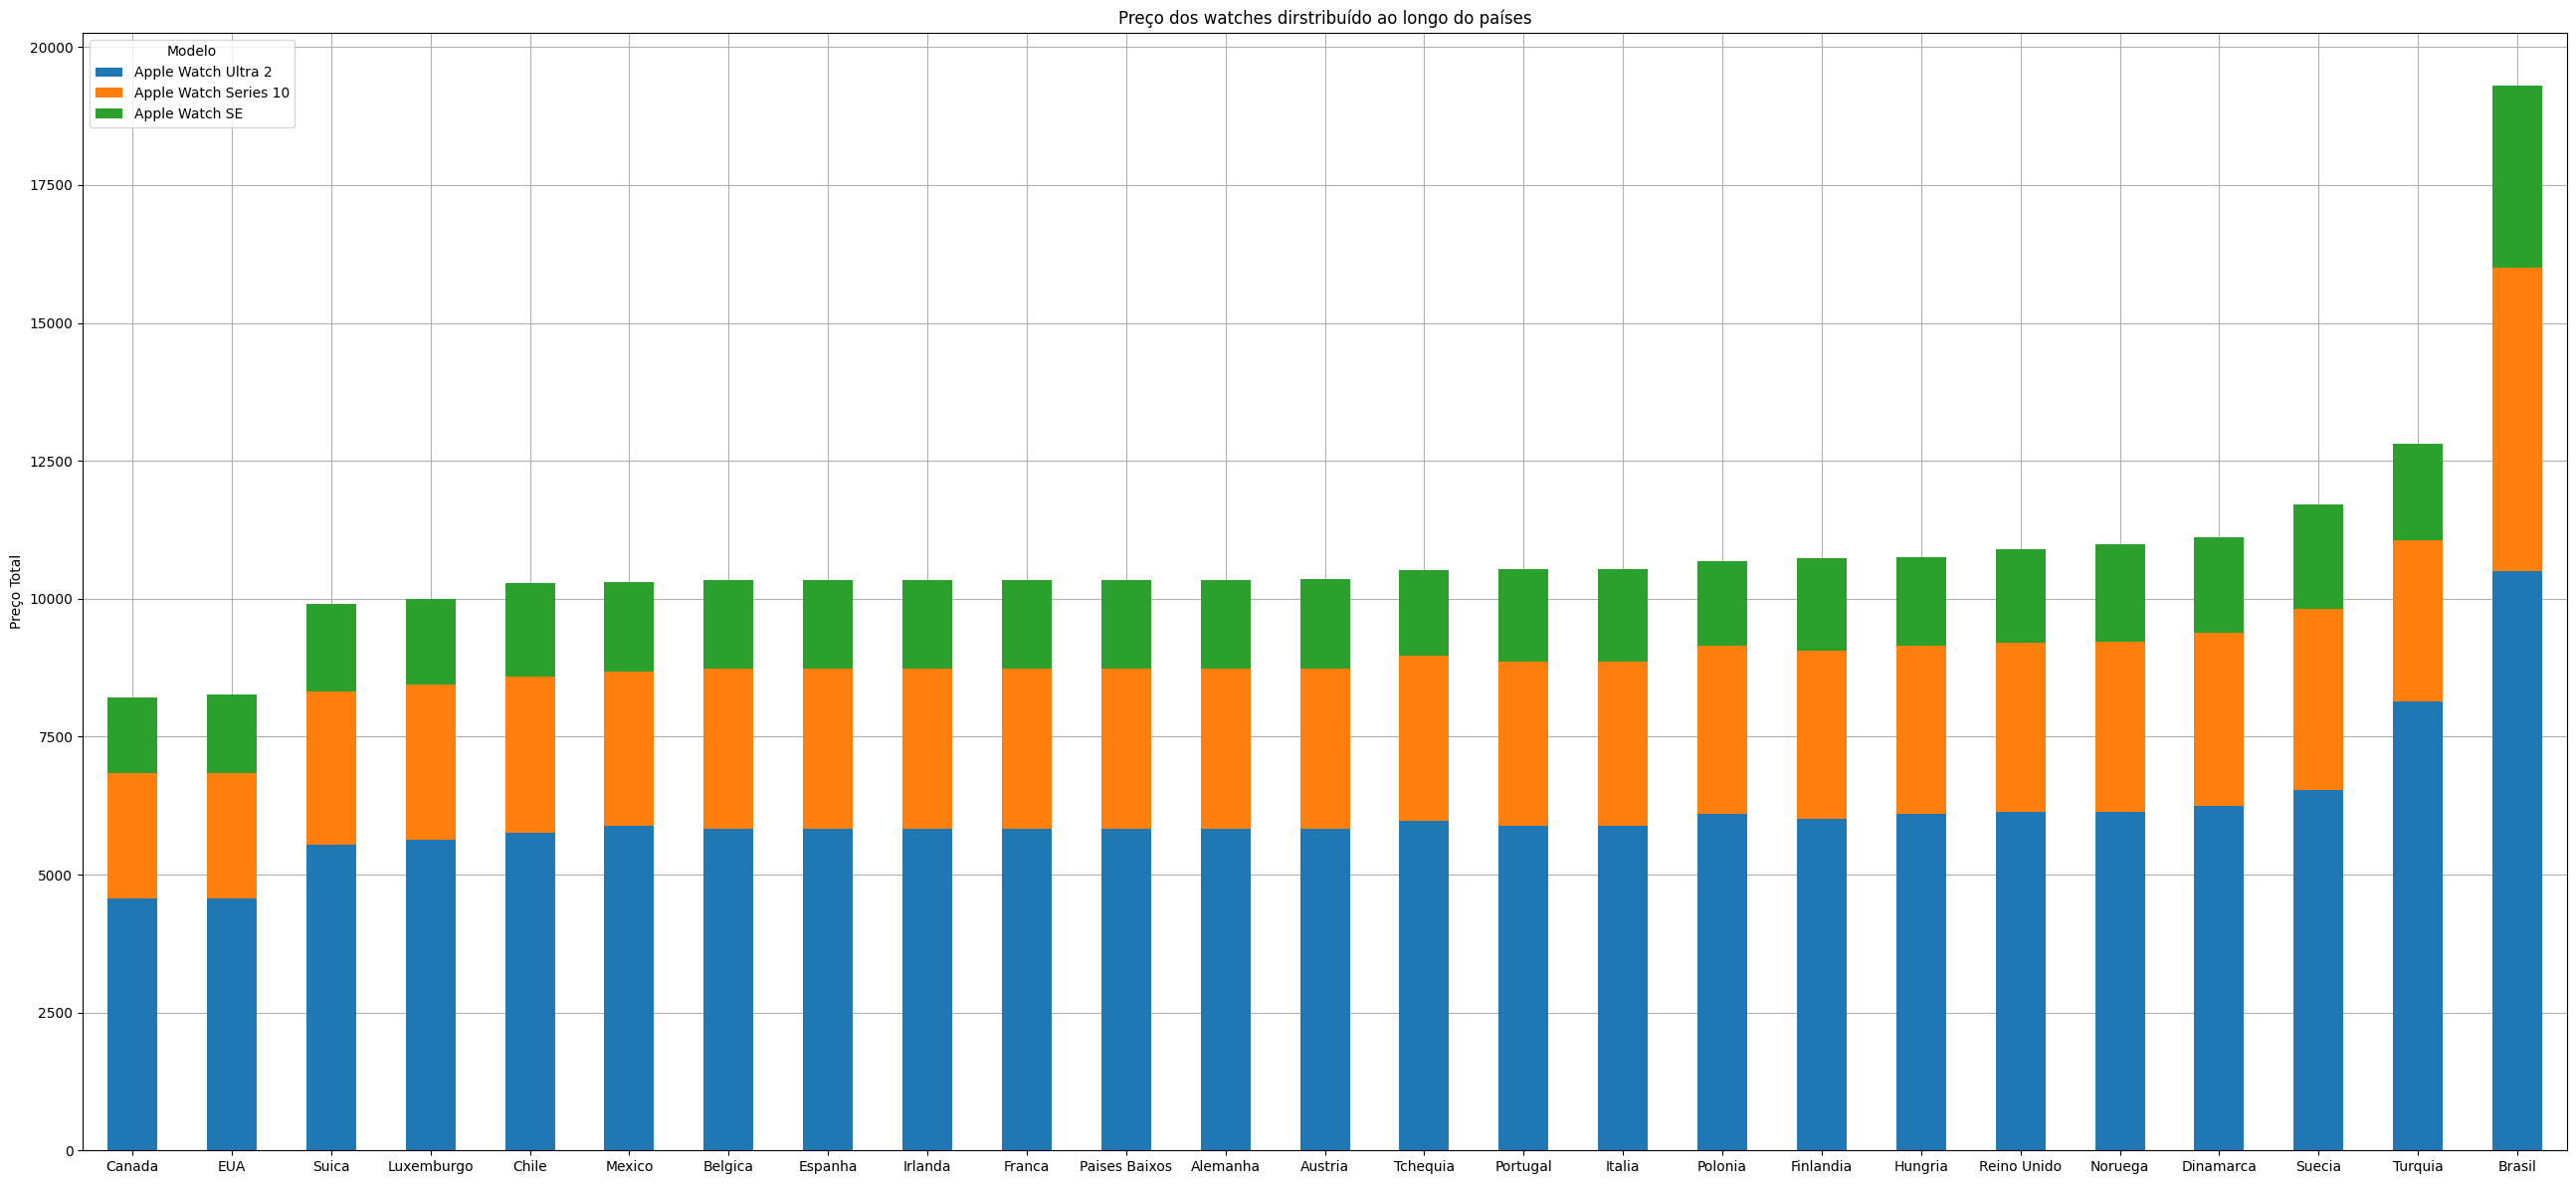

In [86]:
watch_df = data_source_df.drop(columns=['region'])
watch_df = watch_df.drop_duplicates()
watch_df = watch_df[watch_df['category'] == 'watch']
watch_df

pivot_df = watch_df.pivot_table(values='price_brl', index='country', columns='product', aggfunc='sum', fill_value=0)
columns = pivot_df.iloc[3].sort_values(ascending=True).index.to_list()[::-1]
pivot_table = pivot_df.reindex(columns, axis=1)
pivot_table['sum_all'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='sum_all')
pivot_table = pivot_table.drop(columns=['sum_all'])
pivot_table.plot(kind='bar', stacked=True, figsize=(26, 12), zorder=2)
plt.title('Preço dos watches dirstribuído ao longo do países')
plt.xlabel('')
plt.ylabel('Preço Total')
plt.legend(title='Modelo')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.grid(True, zorder=1)
plt.show()

## Quinta Análise - Comparação de Preços de Macs

O gráfico a seguir mostra o granular dos preços da categoria mac distribuído pelos países do gráfico de visão geral. Vale destacar que foi observado que na Turquia, não há o produto Mac Pro exposto na página de macs, e que na Alemanha há o produto Studio Display, porém não é exibido o seu preço por padrão na página de macs. No caso da Alemanha, seria possível pegar o preço mudando a forma de coletânia de dados, que poderia ser implementada em uma versão futura (no caso, pegando diretamente de https://www.apple.com/de/studio-display/ link possível de obter em https://www.apple.com/de/mac/, e que poderia ser usado para pegar os dados de outros países também).

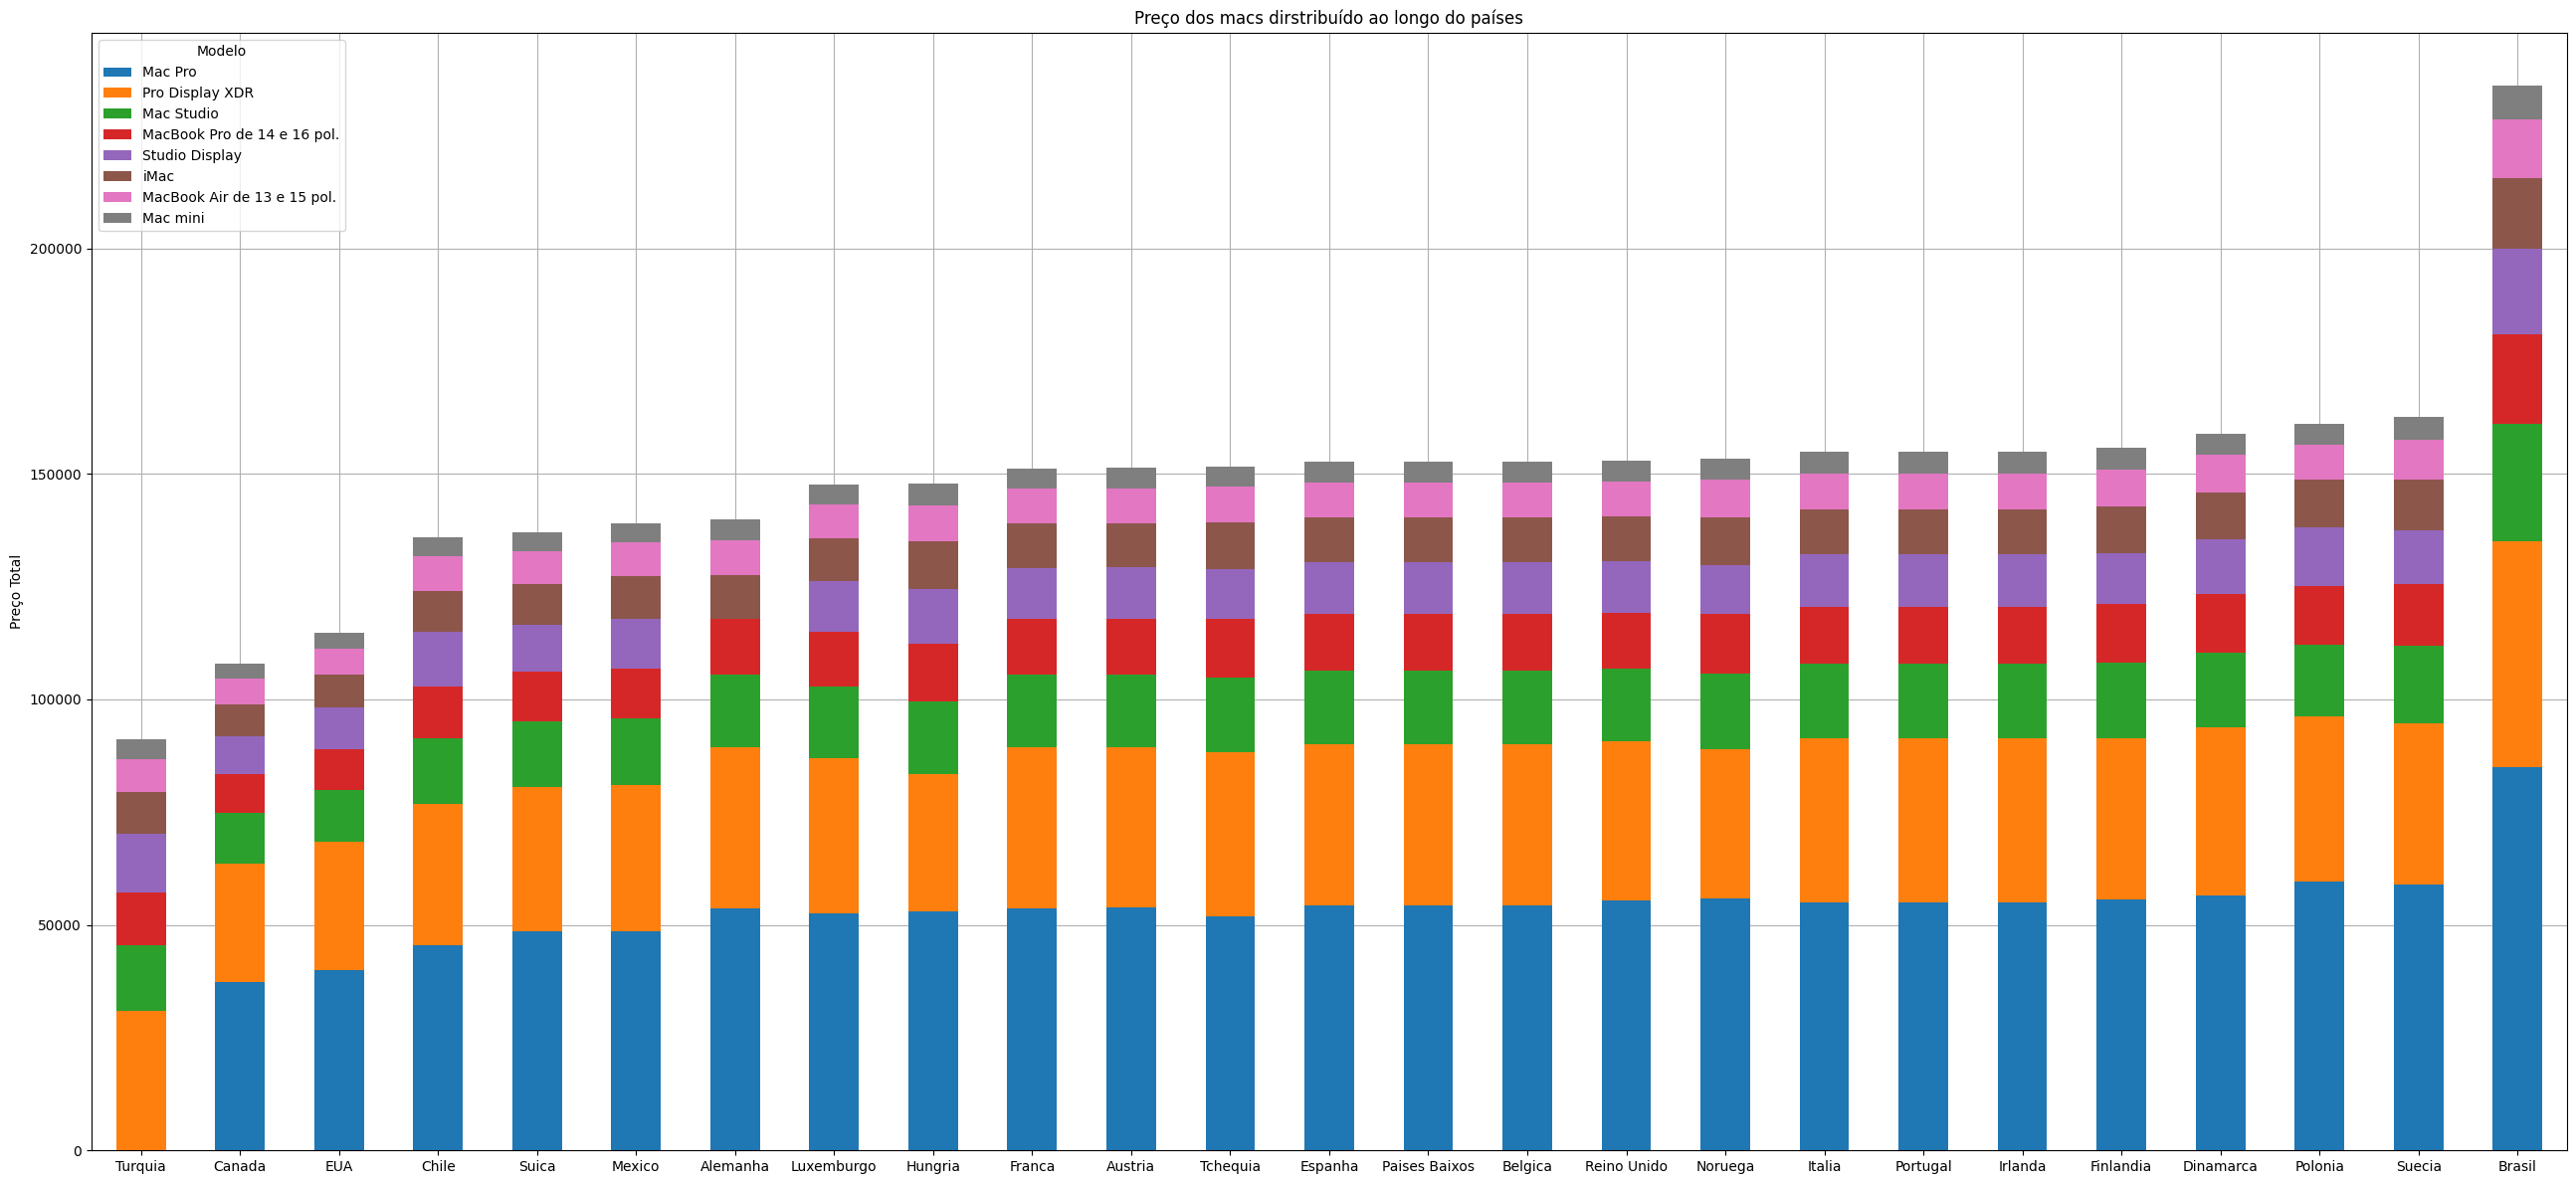

In [85]:
mac_df = data_source_df.drop(columns=['region'])
mac_df = mac_df.drop_duplicates()
mac_df = mac_df[mac_df['category'] == 'mac']
mac_df

pivot_df = mac_df.pivot_table(values='price_brl', index='country', columns='product', aggfunc='sum', fill_value=0)
columns = pivot_df.iloc[3].sort_values(ascending=True).index.to_list()[::-1]
pivot_table = pivot_df.reindex(columns, axis=1)
pivot_table['sum_all'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values(by='sum_all')
pivot_table = pivot_table.drop(columns=['sum_all'])
pivot_table.plot(kind='bar', stacked=True, figsize=(26, 12), zorder=2)
plt.title('Preço dos macs dirstribuído ao longo do países')
plt.xlabel('')
plt.ylabel('Preço Total')
plt.legend(title='Modelo')
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Adjust the layout to make room for the legend
plt.grid(True, zorder=1)
plt.show()